# Introduction to Neural Signal Processing
*Written by Luke Chang*

In this lab we learn the basics of convolution, sine waves, and fourier transforms. This lab is largely based on exercises from Mike X Cohen's excellent book, [Analying Neural Data Analysis: Theory and Practice](https://www.amazon.com/Analyzing-Neural-Time-Data-Practice/dp/0262019876). If you are interested in learning in more detail about the basics of EEG and time-series analyses I highly recommend his accessible introduction. I also encourage you to watch his accompanying freely available [*lecturelets*](http://mikexcohen.com/lectures.html) to learn more about each topic introduced in this notebook.

# Time Domain 

## Dot Product
To understand convolution, we first need to familiarize ourselves with the dot product.  The dot product is simply the sum of the elements of a vector weighted by the elements of another vector. This method is commonly used in signal processing, and also in statistics as a measure of similarity between two vectors. Finally, there is also a geometric inrepretation which is a mapping between vectors (i.e., the product of the magnitudes of the two vectors scaled by the cosine of the angle between them).

$dotproduct_{ab}=\sum\limits_{i=1}^n a_i b_i$

Let's create some vectors of random numbers and see how the dot product works.  First, the two vectos need to be of the same length.

522


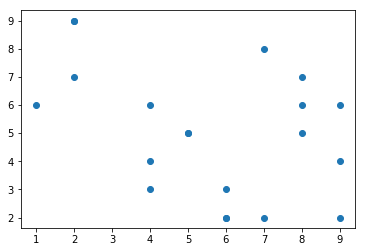

In [108]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

a = np.random.randint(1,10,20)
b = np.random.randint(1,10,20)

plt.scatter(a,b)

print(np.dot(a,b))

what happens when we make the two variables more similar?  In the next example we add gaussian noise on top of one of the vectors.  What happens to the dot product?

In [ ]:
what happens when we make the two variables more similar?  In the next example we add gaussian noise on top of one of the vectors.  What happens to the dot product

722.8499109558313


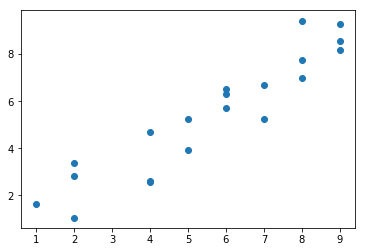

In [112]:
b = a + np.random.randn(20)
plt.scatter(a,b)

print(np.dot(a,b))

## Convolution
Convolution in the time domain is an extension of the dot product in which the dot product is computed iteratively over time.  One way to think about it is that one signal weights each time point of the other signal and then slides forward over time.  Let's call the timeseries variable *signal* and the other vector the *kernel*. Importantly, for our purposes the kernel will almost always be smaller than the signal, otherwise we would only have one scalar value afterwards.

To gain an intuition of how convolution works, let's play with some data. First, let's create a time series of spikes. Then let's convolve this signal with a boxcar kernel.

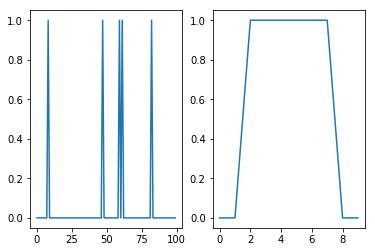

In [163]:
n_samples = 100

signal = np.zeros(n_samples)
signal[np.random.randint(0,n_samples,5)] = 1

kernel = np.zeros(10)
kernel[2:8] = 1

f,a = plt.subplots(ncols=2)
a[0].plot(signal)
a[1].plot(kernel)

Notice how the kernel is only 10 samples long and the boxcar width is about 6 seconds, while the signal is 100 samples long with 5 single pulses.

Now let's convolve the signal with the kernel by taking the dot product of the kernel with each time point of the signal. This can be illustrated by creating a matrix of the kernel shifted each time point of the signal.

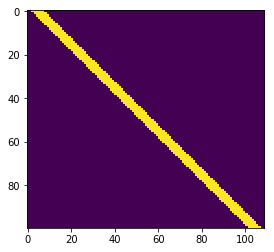

In [164]:
shifted_kernel = np.zeros((n_samples, n_samples+len(kernel) - 1))
for i in range(n_samples):
    shifted_kernel[i, i:i+len(kernel)] = kernel

plt.imshow(shifted_kernel)

Now, let's take the dot product of the signal with this matrix. To refresh your memory from basic linear algebra. Matrix multiplication consists of taking the dot product of the signal vector with each row of this expanded kernel matrix.  

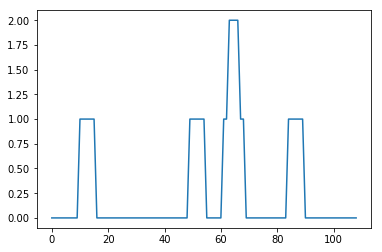

In [165]:
convolved_signal = np.dot(signal,shifted_kernel)

plt.plot(convolved_signal)

You can see that after convolution, each spike has now become the shape of the kernel. Spikes that were closer in time compound if the boxes overlap.

Notice also how the shape of the final signal is the length of the combined signal and kernel minus one.

In [166]:
print("Signal Length: %s" % len(signal))
print("Kernel Length: %s" % len(kernel))
print("Convolved Signal Length: %s" % len(convolved_signal))

Signal Length: 100
Kernel Length: 10
Convolved Signal Length: 109


this process of iteratively taking the dot product of the kernel with each timepoint of the signal and summing all of the values can be performed by using the convolution function from numpy `np.convolve`

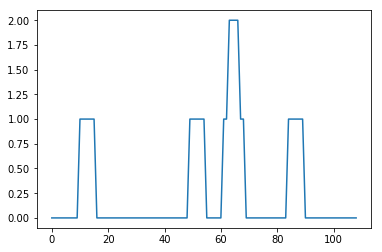

In [167]:
plt.plot(np.convolve(signal, kernel))

What happens if the spikes have different intensities, reflected by different heights?

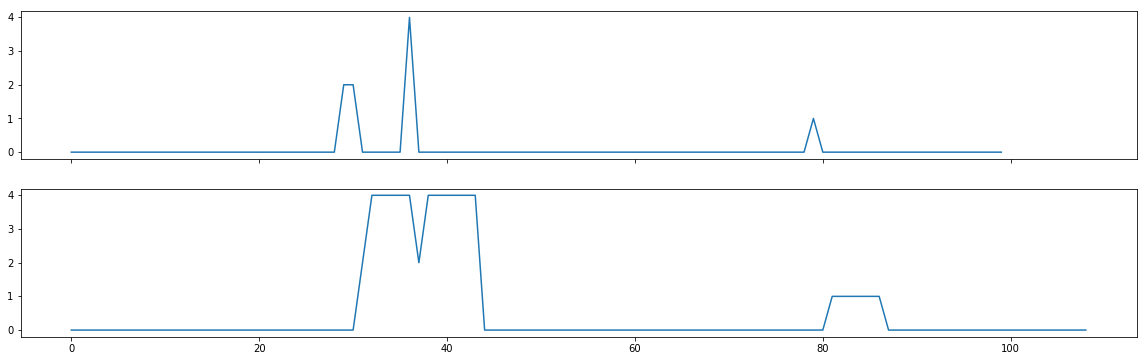

In [188]:
signal = np.zeros(n_samples)
signal[np.random.randint(0,n_samples,5)] = np.random.randint(1,5,5)

f,a = plt.subplots(nrows=2, figsize=(20,6), sharex=True)
a[0].plot(signal)
a[1].plot(np.convolve(signal, kernel))

Now what happens if we switch out the boxcar kernel for something with a more interesting shape, say a hemodynamic response function?  Here we will use a double gamma hemodynamic function (HRF) developed by Gary Glover. 

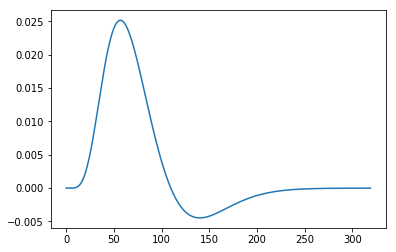

In [180]:
from nltools.external import glover_hrf

tr = 2
hrf = glover_hrf(tr, oversampling=20)
plt.plot(hrf)

For this example, we oversampled the function to make it more smooth.  In practice we will want to make sure that the kernel is the correct shape given our sampling resolution.  Be sure to se the oversampling to 1.  Notice how the function looks more jagged now?

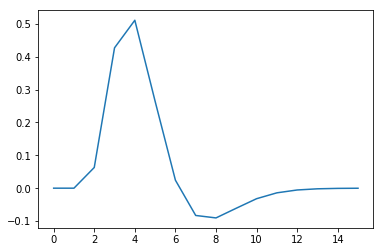

In [182]:
hrf = glover_hrf(tr, oversampling=1)
plt.plot(hrf)

Now let's try convolving our event pulses with this HRF kernel.

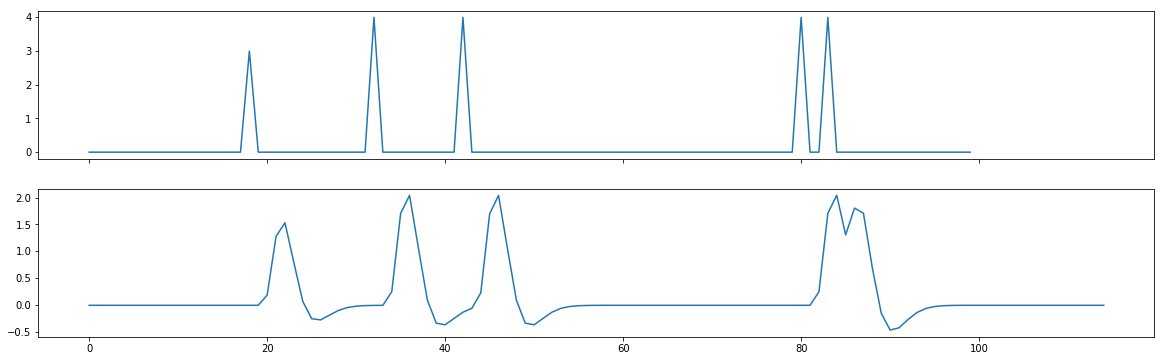

In [187]:
signal = np.zeros(n_samples)
signal[np.random.randint(0,n_samples,5)] = np.random.randint(1,5,5)

f,a = plt.subplots(nrows=2, figsize=(20,6), sharex=True)
a[0].plot(signal)
a[1].plot(np.convolve(signal, hrf))

If you are interested in a more detailed overview of convolution and the HRF function, I encourage you to read this excellent [overview](https://practical-neuroimaging.github.io/on_convolution.html) using python examples. 

## Oscillations

Ok, now let's move on to studying time-varying signals that have the shape of oscillatin waves.

Oscillations can be described mathematically as:

$A\sin(2 \pi ft + \theta)$

where $f$ is the frequency or the speed of the oscillation described in the number of cycles per second - $Hz$. Amplitude $A$ refers to the height of the waves, which is half the distance of the peak to the trough. Finally, $\theta$ describes the phase angle offset, which is in radians.

Check out this short [video](http://mikexcohen.com/lecturelets/sinewave/sinewave.html) for a more in depth explanation of sine waves.

Here we will plot a simple sine wave.  Try playing with the different parameters (i.e., amplitude, frequency, & theta) to gain an intuition of how they each impact the shape of the wave.

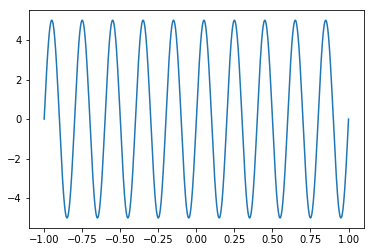

In [189]:
from numpy import sin, pi, arange

sampling_freq = 1000
time = arange(-1, 1 + 1/sampling_freq, 1/sampling_freq)
amplitude = 5
freq = 5
theta = 0

simulation = amplitude * sin(2 * pi * freq * time + theta)
plt.plot(time, simulation)

Next we will generate a simulation combining multiple sine waves oscillating at different frequencies. 

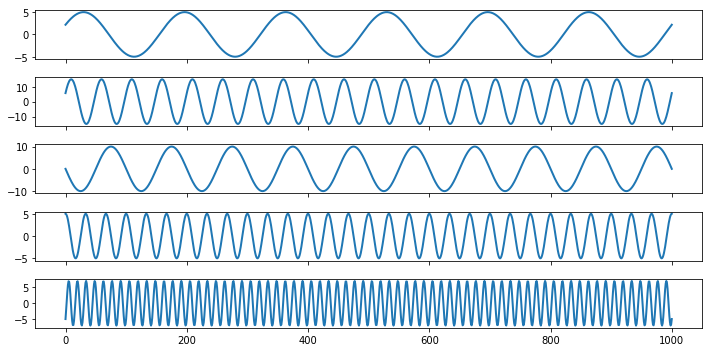

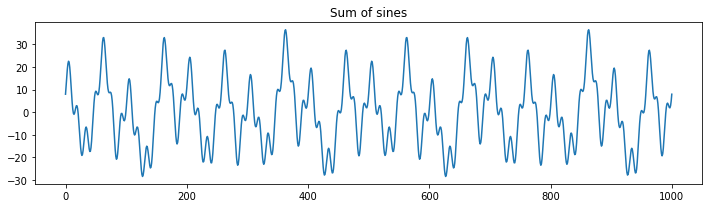

In [93]:
sampling_freq = 500

freq = [3, 10, 5 ,15, 35]
amplitude = [5, 15, 10, 5, 7]
phases = pi*np.array([1/7, 1/8, 1, 1/2, -1/4])

time = arange(-1, 1 + 1/sampling_freq, 1/sampling_freq) 

sine_waves = []
for i,x in enumerate(freq):
    sine_waves.append(amplitude[i] * sin(2*pi*x*time + phases[i]))
sine_waves = np.array(sine_waves)


f,a = plt.subplots(nrows=5, ncols=1, figsize=(10,5), sharex=True)
for i,x in enumerate(freq):
    a[i].plot(sine_waves[i,:], linewidth=2)
plt.tight_layout()    


plt.figure(figsize=(10,3))
plt.plot(np.sum(sine_waves, axis=0))
plt.title("Sum of sines")
plt.tight_layout()    


We can add a little bit of gaussian (white) noise on top of this signal to make it even more realistic

Text(0.5, 1.0, 'Sum of sine waves plus white noise')

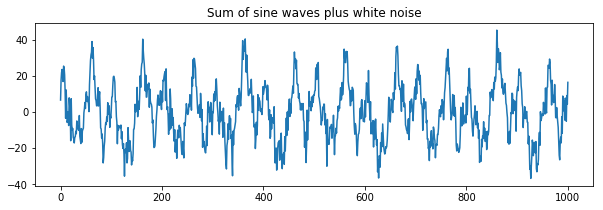

In [215]:
noise = 5 * np.random.randn(sine_waves.shape[1])
signal = np.sum(sine_waves,axis=0) + noise

plt.figure(figsize=(10,3))
plt.plot( signal )
plt.title("Sum of sine waves plus white noise")

# Frequency Domain

In the previous example, we generated a complex signal composed of multiple sine waves oscillating at different frequencies. Typically in data analysis, we only observe the signal and are trying to uncover the generative processes that gave rise to the signal.  In this section, we will introduce the frequency domain and how we can identify if there are any frequencies oscillating at a consistent frequency in our signal using the fourier transform. The fourier transform is essentially convolving different frequencies of sine waves with our data.

## Discrete Time Fourier Transform
We will gain an intution of how the fourier transform works by building our own discrete time fourier transform.

The discrete Fourier transform of variable $x$ at frequency $f$ is

$X_f = \sum\limits_{k=0}^{n-1} x_k e^{-i2\pi f(k-1)n^{-1}}$
 where $n$ refers to the number of data points in vector $x$, and the capital letter $X_f$ is the fourier coefficient of time series variable $x$ at frequency $f$.
 
Essentially, we create a bank of sine waves at different frequencies that are linearly spaced. We will compute n-1 sine waves as the zero frequency component will be the mean offset over the entire signal and will simply be zero in our example.

Notice that we are computing *complex* sine waves using the `np.exp` function instead of the `np.sin` function. `1j` is how we can specify a complex number in python.  We can extract the real components using `np.real` or the imaginary using `np.imag`.

Now let's create a bank of n-1 linearly spaced complex sine waves.


In [262]:
from numpy import exp

time = np.arange(0, len(signal), 1)/len(signal)

sine_waves = []
for i in range(len(signal)):
    sine_waves.append(exp(-1j*2*pi*i*time))
sine_waves = np.array(sine_waves)

Let's look at the first 5 waves to see their frequencies. Remember the first basis function is zero frequency component and reflects the mean offset over the entire signal.

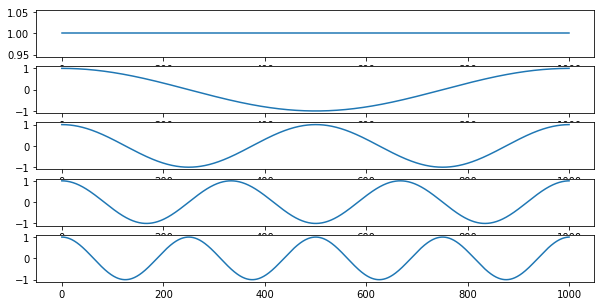

In [266]:
f,a = plt.subplots(nrows=5, figsize=(10,5))
for i in range(0,5):
    a[i].plot(sine_waves[i,:])

We can visualize all of the sine waves simultaneously using a heatmap representation.  Each row is a different sine wave, and columns reflect time.  The intensity of the value is like if the sine wave was coming towards and away rather than up and down. Notice how it looks like that the second half of the sine waves appear to be a mirror image of the first half.  This is because the first half contain the *positive* frequencies, while the second half contains the *negative* frequencies.  Negative frequencies capture sine waves that travel in reverse order around the complex plane compared to that travel forward. This becomes more relevant with the hilbert transform, but for the purposes of this tutorial we will be ignoring the negative frequencies.

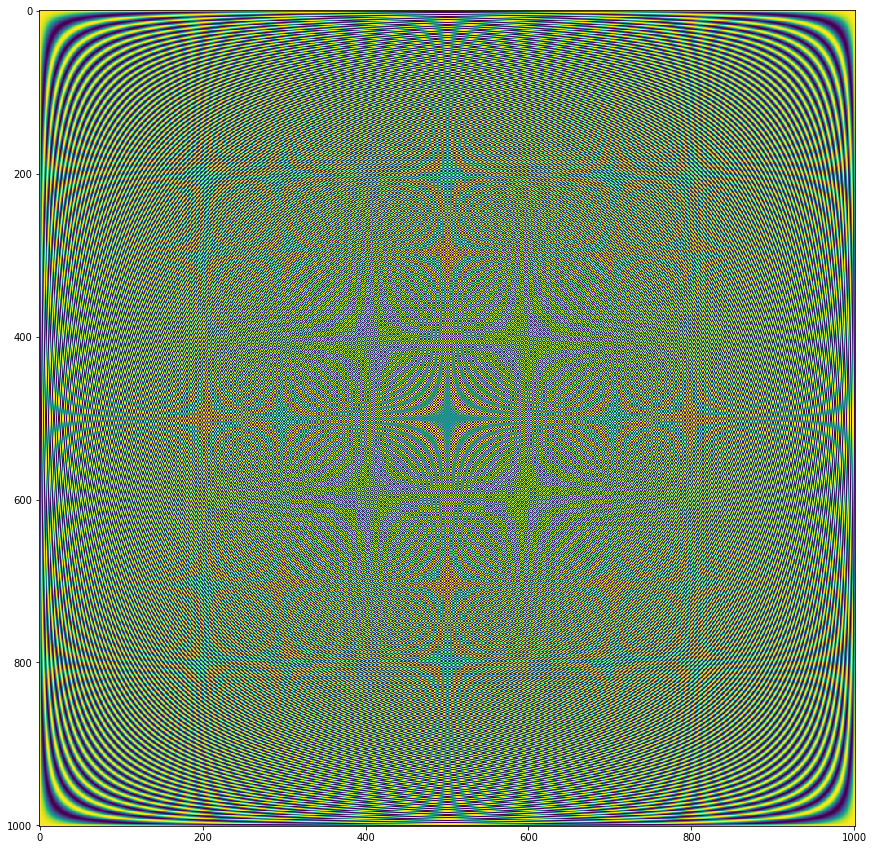

In [267]:
plt.figure(figsize = (15,15))
plt.imshow(np.real(sine_waves))

Now let's take the dot product of each of the sine wave basis set with our signal

In [282]:
fourier = np.dot(signal, sine_waves)

Now that we have computed the fourier transform, we might want to examine the results.  The fourier transform provides a 3-D representation of the data including frquency, power, and phase. Typically, the phase information is ignored when plotting the results of a fourier analysis. The traditional way to view the information is plot the data as amplitude on the *y-axis* and frequency on the *x-axis*. We will extract amplitude by taking the absolute value of the fourier coefficients. Remember that we are only focusing on the positive frequencies (the 1st half of the sine wave basis functions).

Here the x axis simply reflects the index of the frequency.  The actual frequency is $N/2 + 1$ as we are only able estimate frequencies that are half the sampling frequency, this is called the Nyquist frequency.


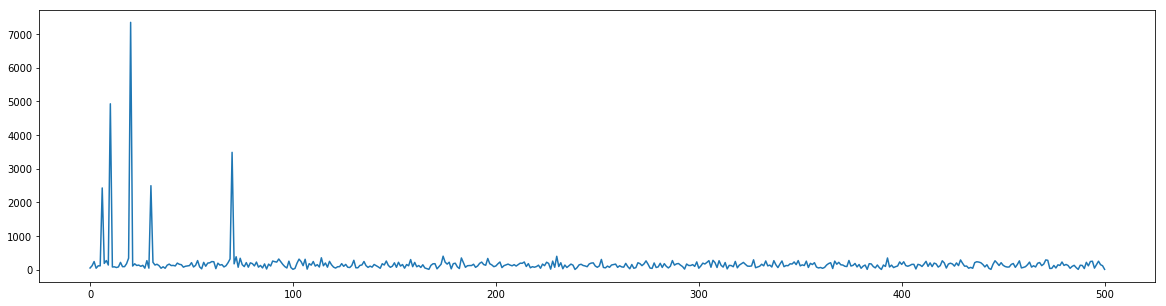

In [284]:
plt.figure(figsize=(20,5))
plt.plot(np.abs(fourier[0:int(np.ceil(len(fourier)/2))]))

Notice that there are 5 different frequencies that have varying amplitudes. Recall that when we simulated this data we added 5 different sine waves with different frequencies and amplitudes. 

`freq = [3, 10, 5 ,15, 35]`
`amplitude = [5, 15, 10, 5, 7]`

Let's zoom in a bit more to see this more clearly and also add the correct frequency labels in $Hz$.

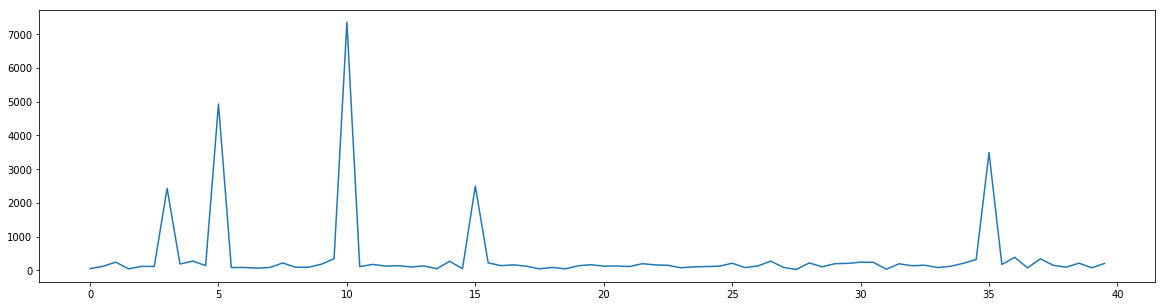

In [289]:
plt.figure(figsize=(20,5))
plt.plot((np.arange(0,80)/2), np.abs(fourier[0:80]))

In [208]:
np.sum(np.dot(sine_wave, signal))

(-186.34451337920876-7.340080659670716e-11j)

## Inverse Fourier Transform

$x_k = \sum\limits_{k=1}^n X_k e^{i2\pi f(k-1)n^{-1}}$

## Fast Fourier Transform

## Stationarity

## Convolution Theorem
Convolution in the time domain is the same multiplication in the frequency domain.  

# Filters

## High Pass

## Low Pass

## Bandpass

## Band-Stop

In [1]:
%matplotlib inline

import os
import glob
import nibabel as nib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltools.data import Brain_Data, Adjacency
from nltools.simulator import Simulator
from nltools.mask import create_sphere
from nltools.stats import align
from nltools.datasets import fetch_localizer

base_dir = '/Users/lukechang/Dropbox/Dartmouth/Teaching/Psych60_HumanBrainImaging/2019S/Homework/5_Preprocessing'


/Users/lukechang/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/Users/lukechang/anaconda3/lib/python3.7/site-packages/socks.py:58: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Callable
/Users/lukechang/anaconda3/lib/python3.7/site-packages/networkx/classes/reportviews.py:95: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping, Set, Iterable


In [13]:
sub_ids = ['S%02d' % x for x in np.arange(1,2)]
f = fetch_localizer(subject_ids=sub_ids, get_anats=False, data_type='preprocessed')


Downloaded 1555 of 1555 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 64001 of 64001 bytes (100.0%,    0.0s remaining) ...done. (4 seconds, 0 min)


In [22]:
print(f.keys())
print(f['functional'])


assert isinstance(f['functional'], list)
assert f['structural'] is None
assert isinstance(f['ext_vars'], pd.DataFrame)

dict_keys(['functional', 'structural', 'ext_vars', 'description'])
[['/Users/lukechang/nilearn_data/brainomics_localizer/brainomics_data/S01/preprocessed_fMRI_bold.nii.gz']]


In [11]:
epi = nib.load('/Users/lukechang/nilearn_data/brainomics_localizer/brainomics_data/S01/preprocessed_fMRI_bold.nii.gz')
epi.data = np.squeeze(epi.get_data())
data = Brain_Data(epi)

/Users/lukechang/anaconda3/lib/python3.7/site-packages/nilearn-0.5.0-py3.7.egg/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


To perform an ICA on your data it is useful to first run a PCA to identify the components that explain the most variance.  Then we run an ICA on the identified principal components. One key step is to first remove the mean from the features of your data.

In [53]:
n_pca_components = 30
n_components = 30
data = data.standardize()
pca_output = data.decompose(algorithm='pca', axis='images', n_components=n_pca_components)
pca_ica_output = pca_output['components'].decompose(algorithm='ica', axis='images', n_components=n_components)

# with sns.plotting_context(context='paper', font_scale=2):
#     sns.heatmap(pca_output['weights'])
#     plt.ylabel('Images')
#     plt.xlabel('Components')
    
# f = pca_output['components'].plot(limit=n_components)

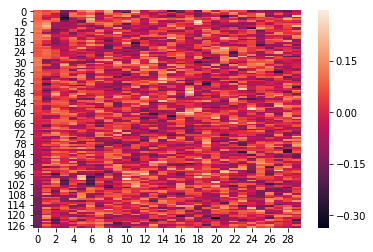

In [56]:
sns.heatmap(pca_output['weights'])

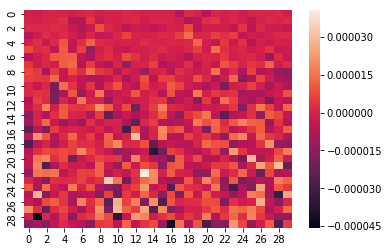

In [54]:
sns.heatmap(pca_ica_output['weights'])

In [55]:
np.dot(pcapca_ica_output['weights'])

array([-5.84524444e-07,  2.49644866e-07,  1.02972636e-06, -6.31667826e-06,
       -5.53854517e-07,  7.87689412e-06, -6.32291457e-06,  4.51320826e-06,
        7.25636722e-06,  5.75422287e-06,  1.08532153e-06,  1.18187483e-06,
       -7.50478777e-06, -3.80959640e-06, -1.38886157e-05, -1.16747673e-05,
       -2.42887923e-05, -6.29824682e-06, -2.66351728e-05, -6.81105890e-06,
       -4.26965810e-06, -5.57845085e-06, -1.28074288e-05,  9.69900755e-07,
        1.01387281e-05, -6.14667315e-06, -3.29411654e-06,  1.97241357e-05,
       -1.02592616e-06, -1.61356631e-05])

threshold is ignored for simple axial plots


/Users/lukechang/anaconda3/lib/python3.7/site-packages/nilearn-0.5.0-py3.7.egg/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/Users/lukechang/anaconda3/lib/python3.7/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


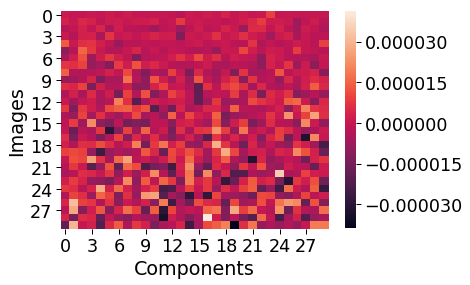

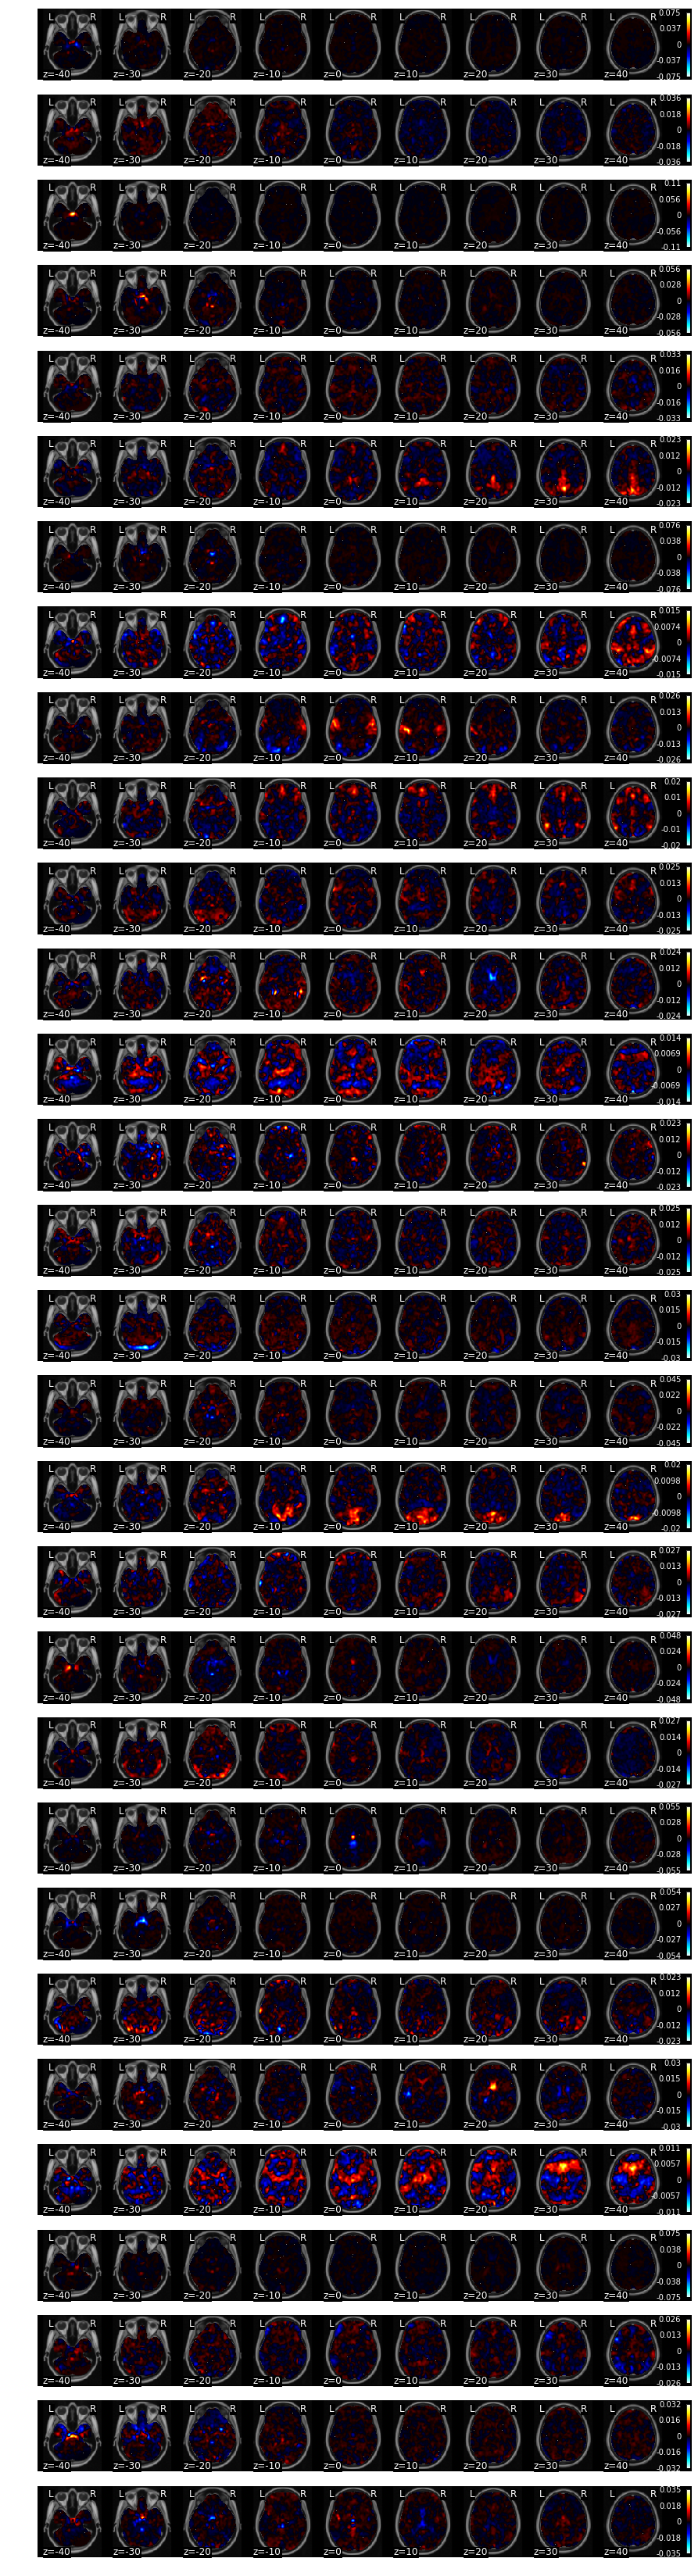

In [42]:
pca_ica_output = pca_output['components'].decompose(algorithm='ica', axis='images')

with sns.plotting_context(context='paper', font_scale=2):
    sns.heatmap(pca_ica_output['weights'])
    plt.ylabel('Images')
    plt.xlabel('Components')

f = pca_ica_output['components'].plot(limit=n_components)

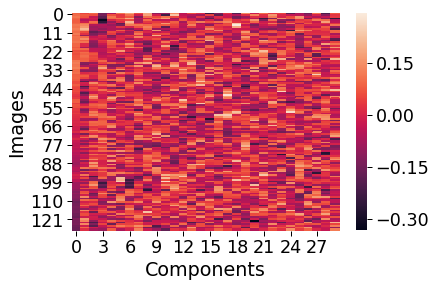

In [21]:
with sns.plotting_context(context='paper', font_scale=2):
    sns.heatmap(pca_output['weights'])
    plt.ylabel('Images')
    plt.xlabel('Components')

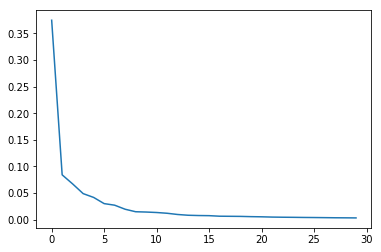

In [36]:
plt.plot(pca_output['decomposition_object'].explained_variance_ratio_)

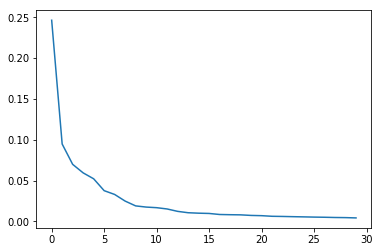

In [33]:
plt.plot(pca_output['decomposition_object'].explained_variance_ratio_)

threshold is ignored for simple axial plots


/Users/lukechang/anaconda3/lib/python3.7/site-packages/nilearn-0.5.0-py3.7.egg/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/Users/lukechang/anaconda3/lib/python3.7/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


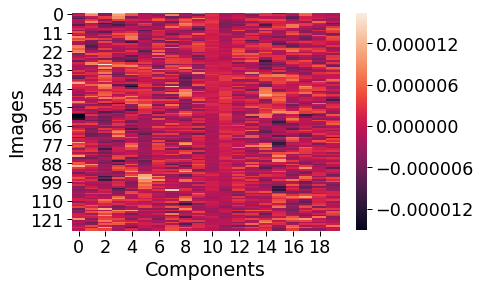

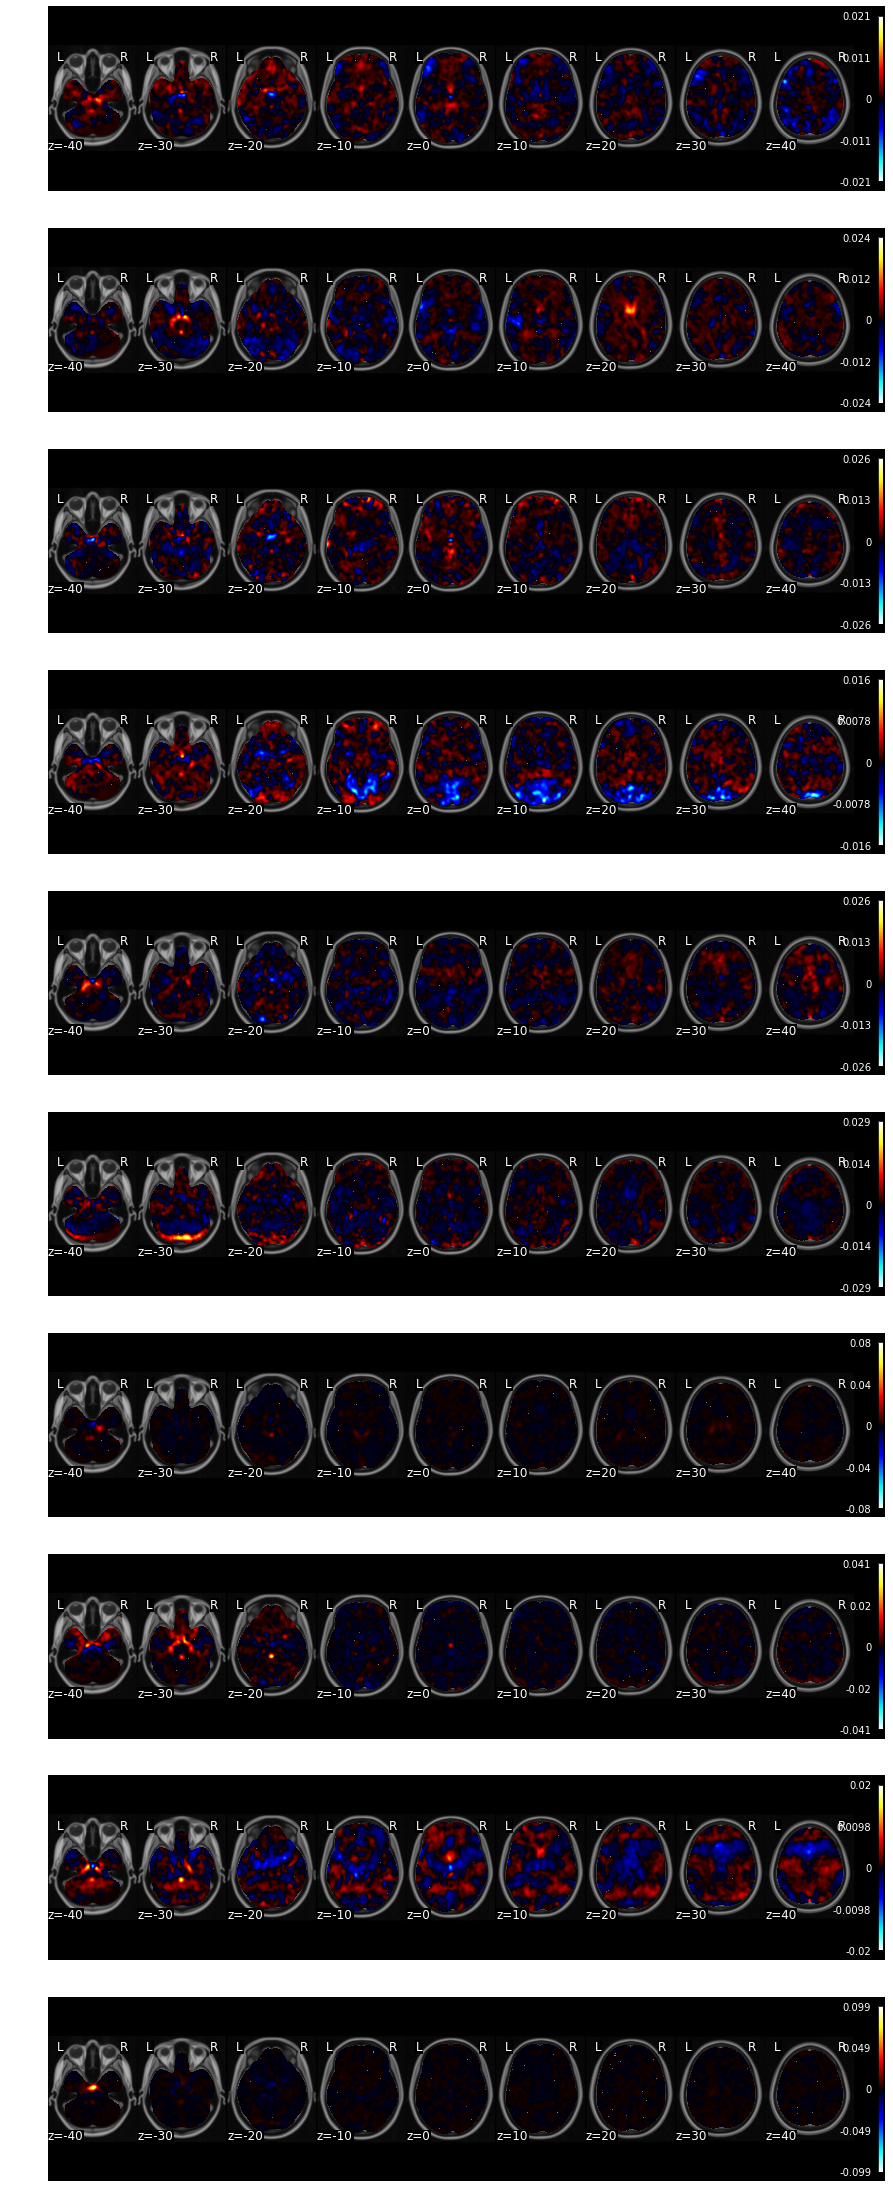

In [28]:
n_components=30

ica_output = data.decompose(algorithm='ica', axis='images', n_components=n_components)

with sns.plotting_context(context='paper', font_scale=2):
    sns.heatmap(ica_output['weights'])
    plt.ylabel('Images')
    plt.xlabel('Components')

f = ica_output['components'].plot(limit=10)

In [34]:
data.decompose?